Math 34A Spring 2022 Grading Script

Import Libraries and Functions

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from grading_functions import version_merger
from grading_functions import letter_grade_assigner
from grading_functions import missed_exam_replacer
from matplotlib import pyplot as plt

Import Files

In [2]:
"""grades is from Gradescope, 
roster is the current student list from egrades, 
webwork is the homework total downloaded from Gauchospace"""
grades = pd.read_csv("Math_34A_Spring_2022_Grades.csv")
roster = pd.read_csv("Math_34A_Spring_2022_Roster.csv")
webwork = pd.read_csv("Math_34A_Spring_2022_Webwork.csv", na_values=["-"])

Creating a Quiz Max Points List quiz_max_points

In [3]:
#Total Quiz Points Column
quiz_point_max_columns = [name for name in grades.columns if "Max Points" in name and "quiz" in name.lower()]
#grades["QPTot"] = grades.apply(lambda row: sum([row[name] for name in quiz_point_max_columns]), axis=1)
quiz_max_points = grades[quiz_point_max_columns].iloc[1].values

1 Renaming columns in all three dataframes for compatability and ease of reading

2 Deleting garbage columns from Gradescope's list

3 Slimming down the egrades roster and webwork roster to include only what we need for student identification

In [4]:
#Renameing "Perm #" to "SID" in Egrades, which may not even be necessary. 
roster.rename(columns = {"Perm #": "SID"}, inplace = True)

#Renaming the same and the Homework column in Webwork
webwork.rename(columns = {"ID number": "SID"}, inplace = True)
webwork.rename(columns = {"External tool:Webwork (Real)": "HWT"}, inplace = True)

#Deleting Garbage Columns
junk_column_indices = [i for i, column in enumerate(grades.columns) \
                       if "Max Points" in column or "Submission Time" in column \
                       or "Lateness" in column or column == "section_name" or column == "Email"]
grades.drop(grades.columns[junk_column_indices], axis=1, inplace=True)

#Renaming Columns: Homework and quizzes (In grades df)
quiz_column_names = [name for name in grades.columns if "quiz" in name.lower()]
grades.rename(columns = {name: "Quiz"+" "+str(i+1) for i, name in enumerate(quiz_column_names)}, inplace = True)

#Roster and Webwork Operations
roster = roster[["Enrl Cd", "SID"]]
webwork = webwork[["SID", "HWT"]]

Merging the versions of Midterm 1 into a new column and dropping the version columns

In [5]:
midterm1_version_list = ["Midterm 1 Gold", "Midterm 1 Blue"]
grades["Midterm 1"] = grades.apply(lambda row: version_merger(row, midterm1_version_list), axis=1)
grades.drop(columns=midterm1_version_list, axis=1, inplace=True)

Debugging code for the upcomming dataframe merge with a description. 

In [6]:
"""The merge below was halted because one perm # begins with an X, 
and I suspect this forced the data type for everything in the 
column imported to be considered an "object". This was fixed by me 
going into the file and changing the perm number with an X in it 
to match the other perm number. Here are two trouble-shooting commands to help with that issue (commented out):"""
#print(roster.SID.info())
#print(grades.SID.info())
#print(roster.SID)
#print(grades.SID)

'The merge below was halted because one perm # begins with an X, \nand I suspect this forced the data type for everything in the \ncolumn imported to be considered an "object". This was fixed by me \ngoing into the file and changing the perm number with an X in it \nto match the other perm number. Here are two trouble-shooting commands to help with that issue (commented out):'

Merge the Three Dataframes

In [7]:
#merging Gradescope and Egrades
grades_merge_one = pd.merge(grades, roster, on="SID", how ="right")
#merging the result and Webwork
grades_for_submission = pd.merge(webwork, grades_merge_one, on="SID", how ="right")

More pruning of columns - I'm not sure if this is necessary because it looks like the same was done for the Gradescope file. Maybe it's also done for the egrades list - and this could be done at the beginning. 

In [8]:
#Prune more columns from general roster
junk_column_indices = [i for i, column in enumerate(grades_for_submission.columns) \
                       if "Pronouns" in column or "Enroll Code" in column \
                       or "Lateness" in column or column == "section_name" or column == "Email"]
grades_for_submission.drop(grades_for_submission.columns[junk_column_indices], axis=1, inplace=True)

Scaling the Midterm Scores to make them out of 100. Their column names are also shortened to make the spreadsheet easier to read when you open the file. 

In [9]:
#Scaling the Midterms
grades_for_submission["M1"] = np.round(grades_for_submission["Midterm 1"]*4, decimals=1)
grades_for_submission["M2"] = np.round(100*grades_for_submission["Midterm 2"]/23, decimals=1)
grades_for_submission["M3"] = np.round(100*grades_for_submission["Midterm 3"]/40, decimals=1)
#Drop Midterm Point Columns
grades_for_submission.drop(columns=["Midterm 1", "Midterm 2", "Midterm 3"], axis=1, inplace=True)

Adjusting Quiz Grades to account for excused absences. 

In [10]:
#Missing Quiz Corrections -- Ugh!
#Starting with Two full quizzes: Trevor's cover left all of the quizzes out on a table in the tea room
trevor_df = pd.read_csv("Excused Tests/Trevor's Students.csv")
trevor_students = list(trevor_df["SID"])
#Quiz Totals List (by quiz number, index needs to be shifted by 1 of course)
#Quiz Replacement (100%)
# def missed_quiz_replacer(row, list, i):
#     if row["SID"] in list:
#         return quiz_max_points[i-1]
#     else:
#         return row["Quiz "+str(i)]
# for i in [4,6]:
#     grades_for_submission["Quiz "+str(i)] = grades_for_submission.apply(lambda row: np.round(missed_quiz_replacer(row,
#                                                                              trevor_students, i), 
#                                                     decimals=1),
#                                 axis=1)
#Quiz Replacement (100%) for everyone else
# for i in range(1,11):
#     quiz_df = pd.read_csv("Excused Tests/Quiz "+str(i)+" Excused Students.csv")
#     students = list(quiz_df["SID"])
#     grades_for_submission["Quiz "+str(i)] = grades_for_submission.apply(lambda row: np.round(missed_quiz_replacer(row,
#                                                                              students, i), 
#                                                     decimals=1),
#                                 axis=1)


In [11]:
missing_quiz_matrix = grades_for_submission[["SID"]].copy()
#excused_list_points
for i in range(1,len(quiz_max_points)+1):
    quiz_df = pd.read_csv("Excused Tests/Quiz "+str(i)+" Excused Students.csv")
    excused_list = list(quiz_df["SID"])
    missing_quiz_matrix["Quiz "+str(i)+"-"] = grades_for_submission.fillna(0).apply(lambda row: (0,quiz_max_points[i-1]) if row["SID"] in excused_list or (i in [4,6] and row["SID"] in trevor_students) else (row["Quiz "+str(i)],0), axis=1)

#print(grades_for_submission.head())
def average_calculator(row):
    points_earned = sum([row["Quiz "+str(i)+"-"][0] for i in range (1,len(quiz_max_points)+1)])
    total_points = sum(quiz_max_points)-sum([row["Quiz "+str(i)+"-"][1] for i in range(1,len(quiz_max_points)+1)])
    if i < 20:
        print(points_earned, total_points, 100*points_earned/total_points)
    return 100*points_earned/total_points
                                            
grades_for_submission["QT"] = missing_quiz_matrix.apply(average_calculator, axis=1)

for i in range(1,len(quiz_max_points)+1):
    grades_for_submission["Quiz "+str(i)] = grades_for_submission.apply(lambda row: np.round(row["QT"]/100*quiz_max_points[i-1], decimals=1) if row["SID"] in excused_list or (i in [4,6] and row["SID"] in trevor_students) else row["Quiz "+str(i)], axis=1)

#grades_for_submission["QT1"] = missing_quiz_matrix["Quiz Average"]

13.0 35 37.142857142857146
0.0 29 0.0
18.0 31 58.064516129032256
23.0 40 57.5
20.0 29 68.96551724137932
19.0 29 65.51724137931035
4.0 18 22.22222222222222
22.0 40 55.0
27.0 29 93.10344827586206
21.0 29 72.41379310344827
11.0 40 27.5
17.0 29 58.62068965517241
14.0 19 73.6842105263158
21.0 35 60.0
19.0 40 47.5
12.0 40 30.0
15.0 37 40.54054054054054
18.0 40 45.0
20.0 26 76.92307692307692
31.0 40 77.5
21.0 29 72.41379310344827
22.0 36 61.111111111111114
25.0 40 62.5
28.0 34 82.3529411764706
22.0 29 75.86206896551724
8.0 29 27.586206896551722
20.0 37 54.054054054054056
22.0 29 75.86206896551724
17.0 37 45.945945945945944
26.0 29 89.65517241379311
26.0 40 65.0
12.0 29 41.37931034482759
19.0 35 54.285714285714285
21.0 40 52.5
5.0 40 12.5
26.0 40 65.0
17.0 40 42.5
27.0 29 93.10344827586206
35.0 40 87.5
14.0 40 35.0
10.0 29 34.48275862068966
9.0 30 30.0
17.0 40 42.5
16.0 32 50.0
32.0 40 80.0
9.0 35 25.714285714285715
22.0 29 75.86206896551724
25.0 29 86.20689655172414
10.0 29 34.48275862068966


Now columns are everywhere! This block sorts the columns and puts the key ones in the front. 

In [12]:
#Let's sort the columns and shorten the name of the data set (so gfs will be grades_for_submission sorted)
gfs_copy = grades_for_submission.copy()
#first_columns = ["First Name", "Last Name", "Enrl Cd", "SID", "Grade", "ClassLevel", "Major1", "Major2"]
first_columns = ["First Name", "Last Name", "Enrl Cd", "SID"]
gfs_copy.drop(first_columns, axis=1, inplace=True)
gfs_copy = gfs_copy[sorted(gfs_copy.columns)]
gfs = gfs_copy.copy()
for i, info_col in enumerate(first_columns):
    gfs.insert(i, info_col, grades_for_submission[info_col], True)

Creating a Quiz Total column and an Adjusted Quiz Total column to account for the Quiz Reflections: x% of their missing points should be added, where x is their score on "Q Reflection for Improvement." I also named the grading item "Q Reflections..." instead of "Quiz Reflections" because otherwise the script above would have renamed it something like "Quiz 11." Finally, I commented out the "QT" column definition because I later used it above to compute a percentage that did not count missed quizzes that were excused. 

In [13]:
#Quiz Total Column
quiz_list=["Quiz "+str(i) for i in range(1,len(quiz_column_names)+1)]
#gfs["QT"] = gfs[quiz_list].sum(axis=1)*100/sum(quiz_max_points)
#Adjusting the Quiz Total to include missing points
missing_quiz_point_multiplier = gfs["Q Reflection for Improvement"].fillna(0)/200
gfs["QTA"] = gfs["QT"] + (100-gfs["QT"])*missing_quiz_point_multiplier

Convert the "Final Exam" raw score into a "Final" entry with a percent value. 

In [14]:
final_point_total = 72
gfs["Final"] = np.round(gfs["Final Exam"]*100/final_point_total, decimals=1)

Excused Missing Midterms will be replaced with the final percentage (that was just calculated). 

In [15]:
#Replacing Midterm Entries for Excused Absences (that midterm is replaced w/ the final score)
for i in range(1,4):
    excused_df = pd.read_csv("Excused Tests/Midterm "+str(i)+" Excused Students.csv")
    students_list = list(excused_df["SID"])
    gfs["M"+str(i)] = gfs.apply(lambda row: np.round(missed_exam_replacer(row,
                                                                             students_list, 
                                                                            "M"+str(i), 
                                                                            "Final"), 
                                                    decimals=1),
                                axis=1)

#Final Replacement will be done below because we need to replace the final with the midterm average

Computing the Midterm Average: First as a raw percentage as the average of the two highest midterms, which is congruent with making the third midterm optional. In practice, I added the three, dropped the minimum, and then divided by two. I could not find a way to just "drop the lowest," though I strongly suspect there is a command for this. 

MTA is the adjusted midterm average, with x% of the missing points returned based on the x% completed for the midterm reflections assignment. 

In [16]:
#Two New Midterm Grade Columns (Raw Average and "MT" that drops the lowest midterm) -- I dropped "Raw Average" below
gfs["Raw Midterm Average"] = gfs.apply(lambda row: (row.fillna(0)["M1"]+row.fillna(0)["M2"]+row.fillna(0)["M3"])/3
                                                                     , axis = 1)
gfs["MT"] = gfs.apply(lambda row: (3*row["Raw Midterm Average"] - np.min([row.fillna(0)["M1"],row.fillna(0)["M2"],
                                                                          row.fillna(0)["M3"]]))/2, axis = 1)
#Adjusting the Midterm Total to include missing points
missing_midterm_point_multiplier = gfs["Exam Reflection for Improvement"].fillna(0)/200
gfs["MTA"] = gfs["MT"] + (100-gfs["MT"])*missing_midterm_point_multiplier
gfs.drop(columns=["Raw Midterm Average"], axis=1, inplace=True)

There were some students who had documented sickness during the final exam. This used the list of SIDs sent to me by my TAs and based on that list, replaced those students' final scores with their adjusted midterm average. 

In [17]:
##Replacing Final Entries for Excused Absences (that midterm is replaced w/ the final score)
final_df = pd.read_csv("Excused Tests/Final Exam Excused Students.csv")
final_missed = list(final_df["SID"])
gfs["Final"] = gfs.apply(lambda row: missed_exam_replacer(row, final_missed, "Final", "MTA"), 
                                axis=1)
#gfs["Final na0"] = gfs["Final"].fillna(0)

Computing the "Grade" and "Letter Grade" columns, now that all of the information is adjusted as intended. 

In [18]:
#Grade Column
gfs["Grade"] = gfs.apply(lambda row: .1*row["QTA"] + .2*row["HWT"] + .4*row["MTA"] + .3*row.fillna(0)["Final"] + 3,
                        axis=1)
    

#Letter Grade Column
gfs["Letter Grade"] = gfs.apply(lambda row: letter_grade_assigner(row), axis=1)

#ordering columns for Egrades Submission and my sanity
first_columns = ["SID", "Enrl Cd", "Letter Grade", "Final", "MTA", "HWT", "QTA"]
temp_columns = gfs[first_columns]
gfs.drop(columns=first_columns, axis=1, inplace=True)
for (i, col_name) in enumerate(first_columns):
    gfs.insert(i, col_name, temp_columns[col_name])

Saving the gfs dataframe as a CSV file. 

In [19]:
#Save gfs df to a file
gfs.to_csv('Math_34A_Winter_2022_Grades_python_output.csv', header=True, index=False)

CSV file for Egrades

In [20]:
##Slim Format for Submission
"Enrl Cd", "SID"
gfs_slim = gfs[["Enrl Cd", "SID", "Letter Grade"]]
gfs_slim.to_csv('Math 34A Egrades List Spring 22.csv', header=True, index=False)

List and Plot of Letter Grades

Grade distribution for the whole class
Letter Grade
A     28
A+    54
A-    23
B     45
B+    19
B-     1
C      2
C+     2
C-     3
D      4
D+     2
F     46
Name: Letter Grade, dtype: int64


<AxesSubplot:xlabel='Letter Grade'>

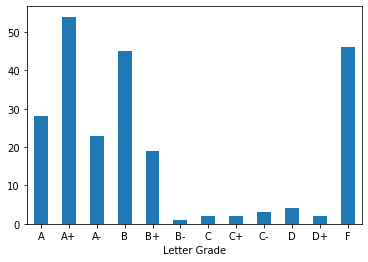

In [21]:
#Letter Grade Distribution
print("Grade distribution for the whole class")
grade_dist = gfs.groupby(by="Letter Grade")
print(grade_dist["Letter Grade"].count())
index = ['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]
letter_grades = gfs["Letter Grade"].count()
df = pd.DataFrame({'Letter Grade': letter_grades}, index=index)

grade_dist["Letter Grade"].count().plot.bar(rot=0)

Same as above, only restricted to students who either took the final or had a documented medical excuse. 


 
 Grade distribution for only students who took the final
Letter Grade
F               46
D-               0
D                4
D+               2
C-               3
C                2
C+               2
B-               1
B               45
B+              19
A-              23
A               28
A+              54
dtype: int64


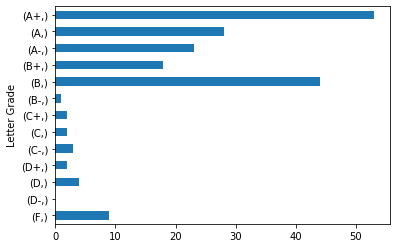

In [22]:
#Letter Grade Distribution  
print("\n","\n","Grade distribution for only students who took the final")
gfs["Letter Grade"] = pd.Categorical(gfs["Letter Grade"], ['F', 'D-', 'D', 
                                                           'D+', "C-", "C", 
                                                           "C+", "B-", "B", 
                                                           "B+", "A-", "A", 
                                                           "A+"], 
                                     ordered = True
                                    )


grade_dist = gfs[["Letter Grade", "Final Exam"]].dropna().groupby(by="Letter Grade")
print(gfs.value_counts(subset=["Letter Grade"])[['F', 'D-', 'D','D+', "C-", "C", 
                                                "C+", "B-", "B", "B+", "A-", "A", "A+"]])
index = ['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]
letter_grades = gfs["Letter Grade"].count()
df = pd.DataFrame({'Letter Grade': letter_grades}, index=index)

gfs[["Letter Grade", "Final Exam"]].dropna().value_counts(subset=["Letter Grade"])[['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]].plot.barh(rot=0)

plt.savefig("Images\Grade Distribution Bar Chart.png")
#grade_dist["Letter Grade"].count().plot.bar(rot=0)

Quantile List for various aspects of the course to get more information, followed by Seaborn Histplots. 

   Percentile       Grade      M1      M2      M3      MT      MTA         QT  \
0        100%  102.655172  100.00  100.00  100.00  100.00  100.000  96.551724   
1         95%  100.314621   98.74   97.80   97.50   96.75   98.300  86.206897   
2         90%   98.587241   94.00   95.70   95.00   96.00   97.005  81.085973   
3         85%   97.584276   92.00   91.30   92.50   93.25   95.790  76.923077   
4         80%   96.099586   88.00   89.10   92.34   91.20   94.660  75.000000   
5         75%   95.055000   86.00   87.00   90.00   89.40   93.150  72.500000   
6         70%   93.598138   78.00   84.07   87.50   86.48   92.225  69.586207   
7         65%   91.601310   72.00   82.60   87.50   85.20   91.040  65.517241   
8         60%   90.438000   70.00   78.30   85.00   81.63   89.015  62.785714   
9         55%   88.938000   66.00   73.90   82.50   78.52   87.570  60.000000   
10        50%   87.560000   62.00   69.60   79.35   76.00   85.050  58.064516   
11        45%   86.096486   

<function matplotlib.pyplot.show(close=None, block=None)>

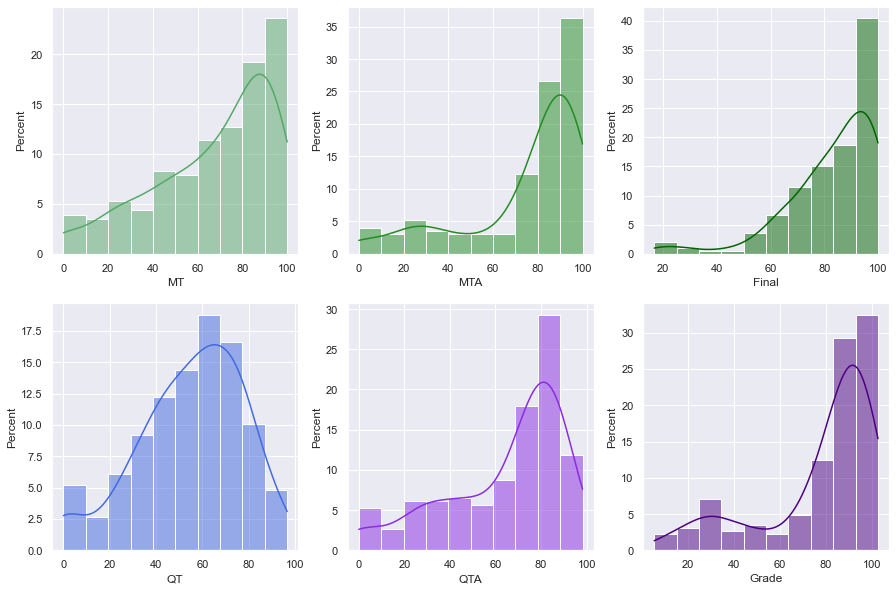

In [23]:
#Making Quantiles for each item
quantiles = pd.DataFrame({
    "Percentile": [str(100-5*n)+"%" for n in range (21)], 
    "Grade": np.quantile([grade for grade in list(gfs["Grade"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M1": np.quantile([grade for grade in list(gfs["M1"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M2": np.quantile([grade for grade in list(gfs["M2"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M3": np.quantile([grade for grade in list(gfs["M3"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "MT": np.quantile([grade for grade in list(gfs["MT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "MTA": np.quantile([grade for grade in list(gfs["MTA"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
#    "Raw Midterm Average": np.quantile([grade for grade in list(gfs["Raw Midterm Average"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
#    "MTot": np.quantile([grade for grade in list(gfs["Raw Midterm Average"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "QT": np.quantile([grade for grade in list(gfs["QT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "QTA": np.quantile([grade for grade in list(gfs["QTA"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "HWT": np.quantile([grade for grade in list(gfs["HWT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "Final": np.quantile([grade for grade in list(gfs["Final"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
})
print(quantiles)


#Plotting Student Scores with Seaborn's histplot
sns.set()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_palette("deep")
#Full Color List (some used below): https://matplotlib.org/stable/gallery/color/named_colors.html
sns.histplot(x=gfs["MT"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,0], color="g")
sns.histplot(x=gfs["MTA"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,1], color="forestgreen")
sns.histplot(x=gfs["Final"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,2], color="darkgreen")
sns.histplot(x=gfs["QT"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,0], color="royalblue")
sns.histplot(x=gfs["QTA"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,1], color="blueviolet")
sns.histplot(x=gfs["Grade"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,2], color="indigo")

plt.savefig("Images\Histplots 1.png")
plt.show

More Seaborn Histplots to contrast performance. 

Midterm Trends
AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.125,0.125;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.125;0.352273x0.343182)


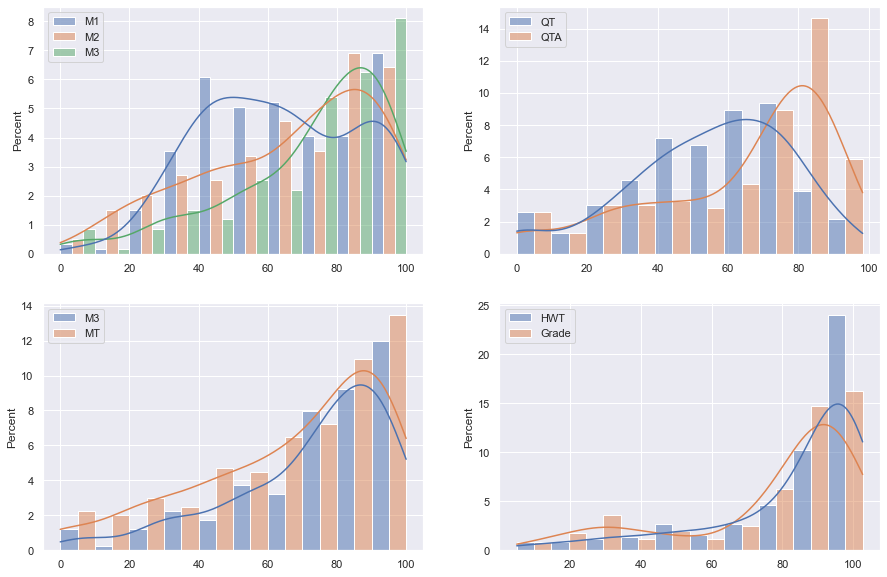

In [24]:
#Midterm Progress in One Vizualization
#sns.displot(gfs["M1"], kde=True, rug=True)
print("Midterm Trends")
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set_palette("deep")
print(sns.histplot(gfs[["M1", "M2", "M3"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[0,0])
     )
print(sns.histplot(gfs[["M3", "MT"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[1,0])
     )
print(sns.histplot(gfs[["QT", "QTA"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[0,1])
     )
print(sns.histplot(gfs[["HWT", "Grade"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[1,1])
     )

plt.savefig("Images\Histplot 2.png")
plt.show()

Miscallaneous Stats (maybe this is bloat)

In [25]:
print("Misc. Stats:")
print(gfs[["M1", "M2", "M3", "MT", "Final"]+["Quiz "+str(i) for i in range(1,9)] + ["QT"]+["HWT"]].describe())

Misc. Stats:
               M1          M2          M3          MT       Final      Quiz 1  \
count  219.000000  202.000000  172.000000  229.000000  193.000000  206.000000   
mean    63.363470   65.690099   72.573837   67.084279   82.863731    4.905340   
std     22.750059   25.441242   22.938776   26.911653   16.941135    0.496839   
min      6.000000    0.000000    2.500000    0.000000   16.700000    1.300000   
25%     44.000000   47.800000   60.000000   49.500000   75.000000    5.000000   
50%     62.000000   69.600000   79.350000   76.000000   87.500000    5.000000   
75%     86.000000   87.000000   90.000000   89.400000   95.800000    5.000000   
max    100.000000  100.000000  100.000000  100.000000  100.000000    5.000000   

           Quiz 2      Quiz 3      Quiz 4      Quiz 5      Quiz 6      Quiz 7  \
count  196.000000  188.000000  199.000000  178.000000  193.000000  174.000000   
mean     1.665306    3.704787    4.140704    1.394944    2.777202    1.662644   
std      1.056